In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.stats as ss
from scipy.stats import norm
import tensorflow as tf 
from tensorflow.keras import layers
import random
from collections import deque


/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
S0,r,sigma,K,T,dt,num_paths,k=100.0, 0.01, 0.2,100.0, 1.0, 1/252, 10000,0


In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [11]:
def generate_black_scholes_paths(S0=S0, r=r, sigma=sigma, T=T, dt=dt, num_paths=num_paths):
    """
    Generate simulated stock price paths using Black-Scholes model.
    
    :param S0:       Initial stock price
    :param r:        Risk-free rate
    :param sigma:    Volatility
    :param T:        Time horizon (in years)
    :param dt:       Time step (in years)
    :param num_paths: Number of simulated paths
    :return:         Array of shape (num_paths, num_time_steps + 1)
                     containing simulated stock paths
    """
    # Number of time steps
    num_steps = int(T / dt)
    
    # Pre-allocate the array for paths
    # We'll store the entire evolution, so shape is (num_paths, num_steps + 1)
    paths = np.zeros(( num_steps + 1))
    
    # Set initial prices
    paths[0] = S0
    
    # Precompute constants for the Euler-Maruyama update
    # Using log-Euler approach: S_{t+dt} = S_t * exp((r - 0.5 sigma^2) dt + sigma sqrt(dt) * Z)
    drift = (r - 0.5 * sigma ** 2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    # Simulate paths
    for t in range(num_steps):
        # Draw random samples from the standard normal distribution
        Z = np.random.normal(0, 1, num_paths)
        # Update in log-space
        paths[t+1] = paths[t] * np.exp(drift + diffusion * Z)
    
    return paths

In [12]:
def call_option_price(S, K, r, sigma, tau):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

In [49]:
class HedgingEnv:
    def __init__(self, initial_stock_price=100, strike_price=100, maturity=1, volatility=0.2, risk_free_rate=0.01, time_steps=15):
        self.initial_stock_price = initial_stock_price
        self.strike_price = strike_price
        self.maturity = maturity
        self.volatility = volatility
        self.risk_free_rate = risk_free_rate
        self.time_steps = time_steps

        self.dt = maturity / time_steps
        self.current_step = 0

        self.stock_paths = None
        self.hedge_position = 0  # H (action to find)
        self.call_option_value = 0

        self.state_space = 3  # [time to maturity, current stock price, current hedge position]
        self.action_space = 10  # Discrete actions: fractions of the stock [-1, -0.9, ..., 0.9, 1]
        self.actions = np.linspace(0, 1, self.action_space)  # Fractions of stock to hold

    def reset(self):
        self.current_step = 0
        self.stock_paths = generate_black_scholes_paths(self.initial_stock_price, self.risk_free_rate, self.volatility, self.maturity, self.dt,1)
        self.hedge_position = 0
        time_to_maturity = self.maturity - self.current_step * self.dt
        current_stock_price = self.stock_paths[self.current_step]
        self.call_option_value = call_option_price(self.stock_paths[self.current_step],self.strike_price,self.risk_free_rate,self.volatility,self.maturity)
        return np.array([time_to_maturity, current_stock_price, self.hedge_position])

    def step(self, action_index):
        action = self.actions[action_index]  # Convert discrete action index to fraction

        # Update time and state
        self.current_step += 1
        time_to_maturity = self.maturity - self.current_step * self.dt
        current_stock_price = self.stock_paths[self.current_step]
        #next_call_option_value = call_option_price(current_stock_price,self.strike_price,self.risk_free_rate,self.volatility, time_to_maturity)
        # Calculate reward based on the provided formula
        # Check if the episode is done
        done = (self.current_step == self.time_steps-1)
        cash_flow = - ((action - self.hedge_position) * current_stock_price  -  np.abs(action - self.hedge_position) * current_stock_price * 0.001)

        #reward = (next_call_option_value - self.call_option_value) + (current_stock_price - self.stock_paths[self.current_step - 1]) * self.hedge_position - 0.025 * abs(current_stock_price * (action - self.hedge_position))
        if done:
            reward = cash_flow + current_stock_price * action - max(current_stock_price - self.strike_price, 0) - action * current_stock_price * 0.001
        else: 
            reward = cash_flow

        # Update hedge position
        self.hedge_position = action
        #self.call_option_value = next_call_option_value

        # Check if the episode is done
        #done = self.current_step >= self.time_steps - 1

        # State is [time to maturity, current stock price, current hedge position]
        state = np.array([time_to_maturity, current_stock_price, self.hedge_position,])

        return state, reward, done


In [50]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size=2000):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


In [51]:
# Define Q-Network
class QNetwork(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_units=128):
        super(QNetwork, self).__init__()
        #self.dense = tf.keras.layers.Input(shape=state_dim)
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_dim, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        x= self.dense3(x)
        q_values = self.output_layer(x)
        return q_values


In [55]:
# Define Deep Q-Learning Agent with Two Q-Networks
class DeepQLearningAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=1.0, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.05, c=0.0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.c = c

        self.q1_network = QNetwork(state_dim, action_dim)
        self.q2_network = QNetwork(state_dim, action_dim)
        self.target_q1_network = QNetwork(state_dim, action_dim)
        self.target_q2_network = QNetwork(state_dim, action_dim)

        self.q1_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.q2_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.update_target_networks()

    def update_target_networks(self):
        self.target_q1_network.set_weights(self.q1_network.get_weights())
        self.target_q2_network.set_weights(self.q2_network.get_weights())

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        state = np.expand_dims(state, axis=0).astype(np.float32)
        q1_values = self.q1_network(state)
        return np.argmax(q1_values.numpy())

    def train(self, replay_buffer, batch_size=32):
        if replay_buffer.size() < batch_size:
            return

        # Sample from replay buffer
        minibatch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int32)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        # Compute target Q-values for Q1 and Q2
        next_q1_values = self.target_q1_network(next_states)
        next_q2_values = self.target_q2_network(next_states)
        max_next_q1_values = np.max(next_q1_values.numpy(), axis=1)
        max_next_q2_values = np.max(next_q2_values.numpy(), axis=1)
        target_q1_values = rewards + self.gamma * max_next_q1_values *(1-dones)
        target_q2_values = rewards ** 2 + (self.gamma)**2 * max_next_q2_values*(1-dones) + 2*self.gamma*rewards*max_next_q2_values*(1-dones)

        # Update Q1 Network
        with tf.GradientTape() as tape:
            q1_values = self.q1_network(states)
            indices = np.arange(batch_size)
            selected_q1_values = tf.reduce_sum(q1_values * tf.one_hot(actions, self.action_dim), axis=1)
            q1_loss = tf.reduce_mean(tf.square(target_q1_values - selected_q1_values))

        q1_grads = tape.gradient(q1_loss, self.q1_network.trainable_variables)
        self.q1_optimizer.apply_gradients(zip(q1_grads, self.q1_network.trainable_variables))

        # Update Q2 Network
        with tf.GradientTape() as tape:
            q2_values = self.q2_network(states)
            selected_q2_values = tf.reduce_sum(q2_values * tf.one_hot(actions, self.action_dim), axis=1)
            q2_loss = tf.reduce_mean(tf.square(target_q2_values - selected_q2_values))

        q2_grads = tape.gradient(q2_loss, self.q2_network.trainable_variables)
        self.q2_optimizer.apply_gradients(zip(q2_grads, self.q2_network.trainable_variables))

        # Decay epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def compute_y_objective(self, state, action):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        q1_value = self.q1_network(state).numpy()[0, action]
        q2_value = self.q2_network(state).numpy()[0, action]
        print(q1_value,'Q1')
        print(q2_value,'Q2')
        return q1_value + self.c * np.sqrt(q2_value - q1_value ** 2)

In [56]:
# Training Loop
def train_deep_q_learning(env, agent, replay_buffer, episodes=300, batch_size=32, target_update_freq=10):
    rewards =[]
    functions =[]
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            #print(next_state, reward, done)
            replay_buffer.add(state, action, reward, next_state, done)
            agent.train(replay_buffer, batch_size)
            state = next_state
            total_reward += reward

        if episode % target_update_freq == 0:
            agent.update_target_networks()
        rewards.append(total_reward)
        y_objective = agent.compute_y_objective(state, action)
        functions.append(y_objective)
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}, Y(0): {y_objective:.2f}")
    return rewards,functions

In [57]:
# Main
if __name__ == "__main__":
    env = HedgingEnv()
    state_dim = env.state_space
    action_dim = env.action_space
    agent = DeepQLearningAgent(state_dim, action_dim)
    replay_buffer = ReplayBuffer(buffer_size=2000)
    rewards,fucntions = train_deep_q_learning(env, agent, replay_buffer)

/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_95016/152808958.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  paths[t+1] = paths[t] * np.exp(drift + diffusion * Z)


0.15904789 Q1
0.42107707 Q2
Episode 0, Total Reward: 4.6721961547446185, Epsilon: 1.00, Y(0): 0.16
4.9232854e-06 Q1
6.9269754e-07 Q2
Episode 1, Total Reward: 9.42530642118411, Epsilon: 1.00, Y(0): 0.00
2.415755e-14 Q1
2.1745405e-15 Q2
Episode 2, Total Reward: -11.176553165853264, Epsilon: 0.90, Y(0): 0.00
6.274502e-08 Q1
6.8034914e-20 Q2
Episode 3, Total Reward: -9.141049900553703, Epsilon: 0.78, Y(0): nan


/var/folders/lc/t3q2r39x05ndfqz7hm78wmkc0000gn/T/ipykernel_95016/684739617.py:83: RuntimeWarning: invalid value encountered in sqrt
  return q1_value + self.c * np.sqrt(q2_value - q1_value ** 2)


6.8243707e-18 Q1
2.584703e-17 Q2
Episode 4, Total Reward: -4.254144226604666, Epsilon: 0.68, Y(0): 0.00
2.1350438e-16 Q1
1.0 Q2
Episode 5, Total Reward: 2.650223679577408, Epsilon: 0.59, Y(0): 0.00
2.4109978e-11 Q1
5.8754376e-11 Q2
Episode 6, Total Reward: -11.708122907387065, Epsilon: 0.51, Y(0): 0.00
1.0 Q1
1.21034875e-11 Q2
Episode 7, Total Reward: -5.328385834480919, Epsilon: 0.44, Y(0): nan
1.8496695e-12 Q1
3.7920378e-10 Q2
Episode 8, Total Reward: -8.62871818192437, Epsilon: 0.38, Y(0): 0.00
1.8723885e-14 Q1
5.6951855e-13 Q2
Episode 9, Total Reward: -6.904461071851088, Epsilon: 0.33, Y(0): 0.00
1.0 Q1
1.7415356e-12 Q2
Episode 10, Total Reward: 4.555559819699649, Epsilon: 0.29, Y(0): nan
1.6883411e-15 Q1
2.2709387e-13 Q2
Episode 11, Total Reward: -3.455056535284996, Epsilon: 0.25, Y(0): 0.00
1.0 Q1
1.5096095e-13 Q2
Episode 12, Total Reward: 2.0822910441421314, Epsilon: 0.22, Y(0): nan
1.0 Q1
2.7135202e-12 Q2
Episode 13, Total Reward: -10.918056169469, Epsilon: 0.19, Y(0): nan
1.0 

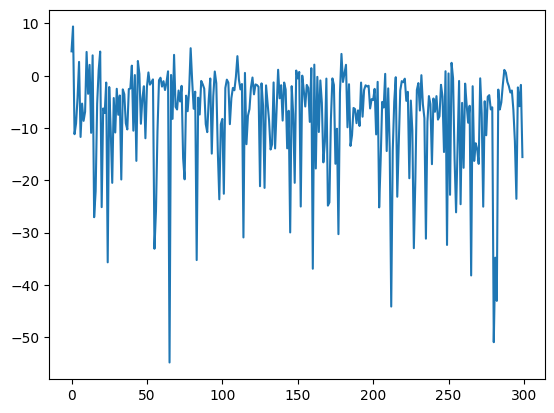

In [58]:
plt.plot(rewards)

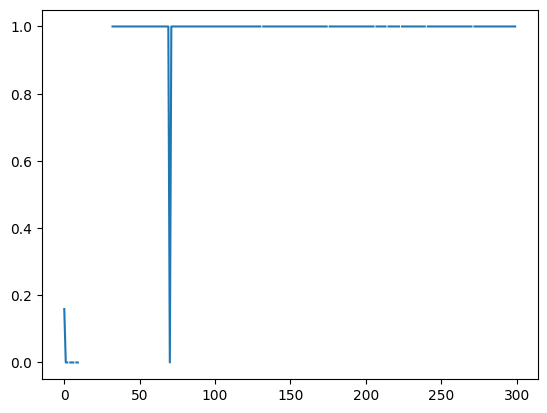

In [59]:
plt.plot(fucntions)